In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from util import load_events, plot_event, create_tracklets, predict_tracklets, create_seeds

## LSTM for classification
#### (called many-to-one LSTM)

In [2]:
events = load_events('toy_dataset.csv', chamber_id=None, start=0, end=2000)

Stations selected are:  [1 2 3 4 5 6]


In [3]:
def pad(arr, off=0):
    '''
    Pad the seqence with zeros to be of required length
    Arguments:
    1. arr (nd.array) : A given numpy array
    2. off (int) : offset, how many entries should be padded ?
    '''
    if off>0:
        updated = np.vstack([arr, np.zeros((off,3))])
        return updated
    else:
        return arr

def create_tracklets(events):
    '''
    A function to create tracklets
    Arguments:
    1. events (list) : A list of events
    '''
    X = []
    y = []
    for event in tqdm(range(len(events))):
        df = events[event]
        if df.empty: continue      
        particle_ids = np.unique(df.particle_id.values)
        df = df[['x','z','a']+['chamber_id','particle_id']]

        df_1 = df.loc[(df.chamber_id==1) | (df.chamber_id==2)]
        df_2 = df.loc[(df.chamber_id==3) | (df.chamber_id==4)]

        list_df_1 = []
        list_df_2 = []
        
        for j in particle_ids:
            track_df_1 = df_1.loc[df_1.particle_id==j, df_1.columns.values]
            track_df_2 = df_2.loc[df_2.particle_id==j, df_2.columns.values]

            track_df_1 = track_df_1.drop(['particle_id','chamber_id'], axis=1)
            list_df_1.append((track_df_1,j))
            track_df_2 = track_df_2.drop(['particle_id','chamber_id'], axis=1)
            list_df_2.append((track_df_2,j))             

            scaler = StandardScaler()
            for df1, pid1 in list_df_1:
                for df2, pid2 in list_df_2:

                    data = pd.concat([df1,df2], axis=0)
                    offset = 24-data.shape[0] # 24 is a perfect track with the correct number of hits
                    if offset<0: continue
                    data = pad(data, offset)
                    data = scaler.fit_transform(data)
                    X.append(data)
                    y.append([int(pid1==pid2)])                

    X = np.stack(X)
    y = np.stack(y)
    return X, y

In [4]:
# create training set
X, y = create_tracklets(events)

100%|██████████| 2000/2000 [01:44<00:00, 19.12it/s]


In [5]:
# invistigate the shaep (batch_size, time_steps, features)
X.shape, y.shape

((115934, 24, 3), (115934, 1))

In [6]:
# LSTM model for classification
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(None, 3)),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.LSTM(50), 
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         41600     
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,851
Trainable params: 71,851
Non-trainable params: 0
_________________________________________________________________


In [7]:
# random splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=1, 
                                                    shuffle=True, 
                                                    stratify=y)

In [8]:
history = model.fit(X_train, y_train, epochs=10, batch_size=4096, validation_split=0.10)

Epoch 1/10
23/23 [==============================] - 32s 1s/step - loss: 0.5748 - accuracy: 0.7294 - val_loss: 0.5155 - val_accuracy: 0.7484
Epoch 2/10
23/23 [==============================] - 31s 1s/step - loss: 0.3343 - accuracy: 0.8446 - val_loss: 0.2069 - val_accuracy: 0.9326
Epoch 3/10
23/23 [==============================] - 30s 1s/step - loss: 0.2063 - accuracy: 0.9148 - val_loss: 0.2036 - val_accuracy: 0.9384
Epoch 4/10
23/23 [==============================] - 32s 1s/step - loss: 0.1694 - accuracy: 0.9402 - val_loss: 0.1620 - val_accuracy: 0.9414
Epoch 5/10
23/23 [==============================] - 30s 1s/step - loss: 0.1962 - accuracy: 0.9313 - val_loss: 0.1776 - val_accuracy: 0.9464
Epoch 6/10
23/23 [==============================] - 30s 1s/step - loss: 0.1419 - accuracy: 0.9547 - val_loss: 0.1701 - val_accuracy: 0.9450
Epoch 7/10
23/23 [==============================] - 30s 1s/step - loss: 0.1332 - accuracy: 0.9592 - val_loss: 0.1422 - val_accuracy: 0.9551
Epoch 8/10
23/23 [==

In [9]:
# Evaluate the model on the test data using `evaluate`
print('Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=1024)

Evaluate on test data
12/12 [==============================] - 2s 161ms/step - loss: 0.1467 - accuracy: 0.9422


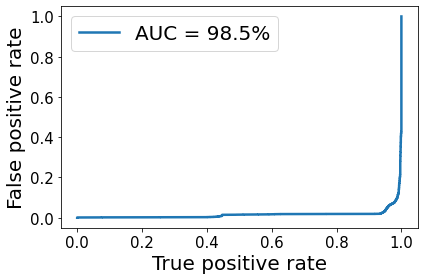

In [10]:
# plot ROC curve
y_pred = model.predict(X_test)
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test[:], y_pred[:])
    
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'True positive rate', fontsize=20)
plt.ylabel(r'False positive rate', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=20)
plt.tight_layout()

In [11]:
# lets predict on one event
df = events[10]
X, hit_ids, ypred = predict_tracklets(df, model)

In [12]:
hit_ids

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15],
       [  0,   1,   2,   3,   4,   5,   6,   7,  32,  33,  34,  35,  36,
         37,  38,  39],
       [  0,   1,   2,   3,   4,   5,   6,   7,  56,  57,  58,  59,  60,
         61,  62,  63],
       [  0,   1,   2,   3,   4,   5,   6,   7,  80,  81,  82,  83,  84,
         85,  86,  87],
       [  0,   1,   2,   3,   4,   5,   6,   7, 104, 105, 106, 107, 108,
        109, 110, 111],
       [  0,   1,   2,   3,   4,   5,   6,   7, 128, 129, 130, 131, 132,
        133, 134, 135],
       [  0,   1,   2,   3,   4,   5,   6,   7, 152, 153, 154, 155, 156,
        157, 158, 159],
       [ 24,  25,  26,  27,  28,  29,  30,  31,   8,   9,  10,  11,  12,
         13,  14,  15],
       [ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
         37,  38,  39],
       [ 24,  25,  26,  27,  28,  29,  30,  31,  56,  57,  58,  59,  60,
         61,  62,  63],
       [ 24,  25,  26,  27,  2

In [13]:
# what are the indices of the tracklets that pass the cut
np.argwhere(ypred.flatten()>0.5).flatten()

array([ 0,  1,  3,  5,  8, 12, 16, 21, 22, 24, 26, 32, 36, 40, 48])

In [14]:
# hit_ids shape
hit_ids.shape

(49, 16)

In [15]:
hit_ids[np.argwhere(ypred.flatten()>0.5).flatten(),:]

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15],
       [  0,   1,   2,   3,   4,   5,   6,   7,  32,  33,  34,  35,  36,
         37,  38,  39],
       [  0,   1,   2,   3,   4,   5,   6,   7,  80,  81,  82,  83,  84,
         85,  86,  87],
       [  0,   1,   2,   3,   4,   5,   6,   7, 128, 129, 130, 131, 132,
        133, 134, 135],
       [ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
         37,  38,  39],
       [ 24,  25,  26,  27,  28,  29,  30,  31, 128, 129, 130, 131, 132,
        133, 134, 135],
       [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63],
       [ 72,  73,  74,  75,  76,  77,  78,  79,   8,   9,  10,  11,  12,
         13,  14,  15],
       [ 72,  73,  74,  75,  76,  77,  78,  79,  32,  33,  34,  35,  36,
         37,  38,  39],
       [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87],
       [ 72,  73,  74,  75,  7

In [16]:
# plot found track
track_id  = hit_ids[np.argwhere(ypred.flatten()>0.5).flatten(),:]
reco_track = df[df['hit_id'].isin(track_id[2])]

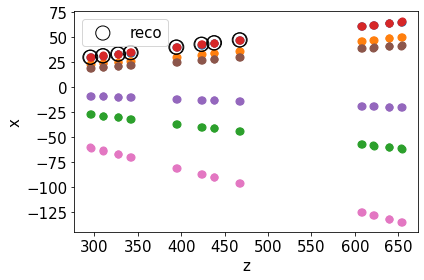

In [17]:
plot_event(df)
plt.scatter(reco_track.z, reco_track.x, s=200, facecolors='none', edgecolors='black', label='reco')
plt.legend(fontsize=15)

## LSTM for prediction
#### (called many-to-many LSTM)

In [18]:
# a seed is a track of 4-hits in the first chamber
X, y = create_seeds(events)

100%|██████████| 2000/2000 [00:14<00:00, 140.33it/s]


In [19]:
# invistigate the shape
X.shape, y.shape

((9109, 4, 3), (9109, 4, 3))

In [20]:
# LSTM model for prediction
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(None, 3)),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.LSTM(50, return_sequences=True), 
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3)),
  tf.keras.layers.Activation('linear')
])

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 100)         41600     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 50)          30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 3)           153       
_________________________________________________________________
activation (Activation)      (None, None, 3)           0         
Total params: 71,953
Trainable params: 71,953
Non-trainable params: 0
__________________________________________________

In [21]:
history = model.fit(X, y, epochs=200, batch_size=4096, validation_split=0.10)

Epoch 1/200
3/3 [==============================] - 1s 376ms/step - loss: 39.2854 - val_loss: 39.4613
Epoch 2/200
3/3 [==============================] - 0s 113ms/step - loss: 37.5709 - val_loss: 37.7654
Epoch 3/200
3/3 [==============================] - 0s 114ms/step - loss: 35.9307 - val_loss: 36.0733
Epoch 4/200
3/3 [==============================] - 0s 101ms/step - loss: 34.2987 - val_loss: 34.3807
Epoch 5/200
3/3 [==============================] - 0s 116ms/step - loss: 32.6522 - val_loss: 32.7071
Epoch 6/200
3/3 [==============================] - 0s 151ms/step - loss: 31.0175 - val_loss: 30.9985
Epoch 7/200
3/3 [==============================] - 0s 142ms/step - loss: 29.3631 - val_loss: 29.2913
Epoch 8/200
3/3 [==============================] - 0s 113ms/step - loss: 27.7263 - val_loss: 27.6426
Epoch 9/200
3/3 [==============================] - 0s 105ms/step - loss: 26.1195 - val_loss: 26.0338
Epoch 10/200
3/3 [==============================] - 0s 120ms/step - loss: 24.5956 - val_los

3/3 [==============================] - 0s 123ms/step - loss: 2.3494 - val_loss: 2.2833
Epoch 83/200
3/3 [==============================] - 0s 136ms/step - loss: 2.3127 - val_loss: 2.2499
Epoch 84/200
3/3 [==============================] - 0s 153ms/step - loss: 2.2815 - val_loss: 2.2177
Epoch 85/200
3/3 [==============================] - 0s 94ms/step - loss: 2.2460 - val_loss: 2.1929
Epoch 86/200
3/3 [==============================] - 0s 118ms/step - loss: 2.2270 - val_loss: 2.1718
Epoch 87/200
3/3 [==============================] - 0s 114ms/step - loss: 2.2133 - val_loss: 2.1344
Epoch 88/200
3/3 [==============================] - 0s 111ms/step - loss: 2.1721 - val_loss: 2.1000
Epoch 89/200
3/3 [==============================] - 0s 105ms/step - loss: 2.1419 - val_loss: 2.0632
Epoch 90/200
3/3 [==============================] - 0s 117ms/step - loss: 2.1075 - val_loss: 2.0231
Epoch 91/200
3/3 [==============================] - 0s 121ms/step - loss: 2.0651 - val_loss: 1.9811
Epoch 92/200
3

3/3 [==============================] - 0s 100ms/step - loss: 0.9641 - val_loss: 0.7949
Epoch 164/200
3/3 [==============================] - 0s 112ms/step - loss: 0.9533 - val_loss: 0.7903
Epoch 165/200
3/3 [==============================] - 0s 103ms/step - loss: 0.9410 - val_loss: 0.7706
Epoch 166/200
3/3 [==============================] - 0s 107ms/step - loss: 0.9371 - val_loss: 0.7653
Epoch 167/200
3/3 [==============================] - 0s 102ms/step - loss: 0.9274 - val_loss: 0.7585
Epoch 168/200
3/3 [==============================] - 0s 113ms/step - loss: 0.9195 - val_loss: 0.7463
Epoch 169/200
3/3 [==============================] - 0s 132ms/step - loss: 0.9036 - val_loss: 0.7401
Epoch 170/200
3/3 [==============================] - 0s 120ms/step - loss: 0.9073 - val_loss: 0.7319
Epoch 171/200
3/3 [==============================] - 0s 120ms/step - loss: 0.8972 - val_loss: 0.7255
Epoch 172/200
3/3 [==============================] - 0s 104ms/step - loss: 0.8856 - val_loss: 0.7208
Epoc

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <a list of 11 Text major ticklabel objects>)

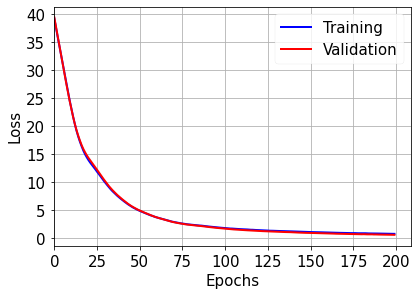

In [22]:
plt.style.use('seaborn-paper')
valid = history.history

plt.plot(np.array(valid['loss']), label='Training',  color='blue', linewidth= 2)
plt.plot(np.array(valid['val_loss']), label='Validation',  color='red', linewidth= 2)
plt.xlim(0)
plt.grid(True)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [23]:
# is it good enough (just by eye)
print (model.predict(X[0:1]), '\n\n', y[0:1])

[[[0.86548334 3.3237326  3.0313702 ]
  [1.0656813  3.280413   3.1723301 ]
  [1.0982907  3.2995045  3.2949293 ]
  [1.1338223  3.326379   3.377006  ]]] 

 [[[1.0593     3.26895    3.23935652]
  [1.0618     3.2777     3.23833423]
  [1.1015     3.4139     3.22539618]
  [1.104      3.42265    3.22445287]]]


### can you implement a kD-Tree to search for the nearest neighbors
look at [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html)